# Mask Generation

In [18]:
from climpyrical.mask import *
from climpyrical.gridding import *
from climpyrical.data import read_data, interpolate_dataset, gen_dataset

from tqdm import tqdm
import matplotlib.pyplot as plt
import geopandas as gpd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate Mask from High-Res Model

The original CanRCM4 model comes with 50km x 50km grid cells. These need to be increased to the final NRC resolution of 5 km x 5 km grid cells.

The only available land masks for CanRCM4 models are at the native resolution, and miss out on finer detailed coastlines. 

Fix this by using more detailed shapefiles that can clip a raster. 

In [19]:
# from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/cultural/ne_50m_admin_1_states_provinces.zip
s = gpd.read_file('/home/nannau/nrc_data/ne_50m_admin_1_states_provinces.shp')

# select Canada only
c = s[s.iso_a2 == "CA"]

# transform to rotated pole CRS 
rp_c = rotate_shapefile(c.geometry)

/home/nannau/09092020/climpyrical/climpyrical/mask.py:49: UserWarning: Polygon provided is in projection epsg:4326, expected {'init': 'epsg:4326'} or epsg:4326.                 Other transformations are experimental and have not been tested.
  p: Union[gpd.GeoSeries, gpd.GeoDataFrame],


In [20]:
# from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/physical/ne_10m_lakes.zip
# note that 50m does not include great lakes for unknown reasons
lakes = gpd.read_file('/home/nannau/nrc_data/ne_10m_lakes.shp')

# select only larger lakes
g_lakes = lakes[lakes.area >= 0.2]#'Great Lakes']
g_lakes = rotate_shapefile(g_lakes.geometry)

# remove lakes from mask
canada = gpd.overlay(gpd.GeoDataFrame(rp_c), gpd.GeoDataFrame(g_lakes), how='difference')

/home/nannau/09092020/climpyrical/climpyrical/mask.py:49: UserWarning: Polygon provided is in projection epsg:4326, expected {'init': 'epsg:4326'} or epsg:4326.                 Other transformations are experimental and have not been tested.
  p: Union[gpd.GeoSeries, gpd.GeoDataFrame],


In [52]:
from climpyrical.mask import gen_raster_mask_from_vector
from pkg_resources import resource_filename

mask_ds = read_data(
    resource_filename("climpyrical", "tests/data/canada_mask_rp.nc")
)

canada = gpd.read_file(
    resource_filename("climpyrical", "tests/data/canada.geojson")
).geometry

# rotate the vectors using the to_crs method. GeoPandas does
# not preserve the crs that's defined, otherwise a standalone
# pre-projected in rotated pole polygon would be used
rotated_crs = {
    "proj": "ob_tran",
    "o_proj": "longlat",
    "lon_0": -97,
    "o_lat_p": 42.5,
    "a": 6378137,
    "to_meter": 0.0174532925199,
    "no_defs": True,
    
    
}

rotated_canada = canada.to_crs(rotated_crs)
# print(rotated_canada.bounds.minx.min(), mask_ds.rlon.values[300:500])
gen_raster_mask_from_vector(mask_ds.rlon.values[::10], mask_ds.rlat.values[::10], rotated_canada, True).shape


100%|██████████| 10509/10509 [00:01<00:00, 6224.90it/s]


(151, 155)

Text(0.5, 1.0, 'Rotated Shapefile with Great Lakes Removed')

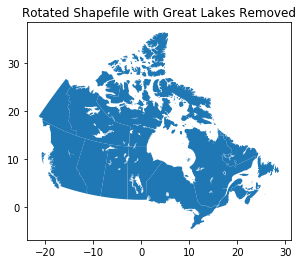

In [4]:
canada.plot()
plt.title('Rotated Shapefile with Great Lakes Removed')

# Create raster using example ensemble mask for CanRCM4 model

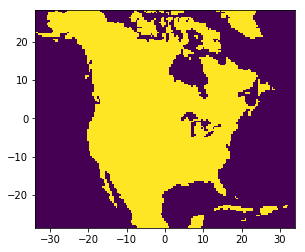

In [5]:
# PCIC internal. Available upond request
PATH_MEAN = '/home/nannau/nrc_data/land_mask_CanRCM4_sftlf.nc'

mask = read_data(PATH_MEAN)
key = 'sftlf'
    
# assign physical coordinates on axis
extent = [mask.rlon.min(), mask.rlon.max(), mask.rlat.min(), mask.rlat.max()]
    
# view mask
plt.imshow(mask[key], origin='lower', extent=extent)

# Change default mask resolution to final resolution by copying grid cells

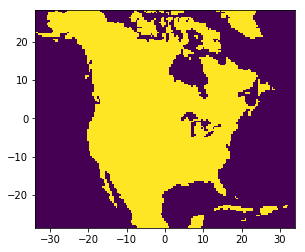

In [13]:
N = 10
mask10 = regrid_ensemble(mask, key, N, ['rlon', 'rlat'], copy=True)

plt.imshow(mask10[key], origin='lower', extent=extent)

In [7]:
interpolate_dataset?

Signature: interpolate_dataset(points, values, target_points, method)
Docstring: <no docstring>
File:      ~/09092020/climpyrical/climpyrical/data.py
Type:      function


# Extend northern region
Extend CanRCM4 models to include regions in then north (i.e. Nunuvut). Add rows of pixels to north. This can be done before or after regridding to high-res - so long as it sufficiently covers Nunuvut. 

In [14]:
mask10_ext = extend_north(mask10, key, 210, fill_val=False)
new_extent = [mask10_ext.rlon.min(), mask10_ext.rlon.max(), mask10_ext.rlat.min(), mask10_ext.rlat.max()]

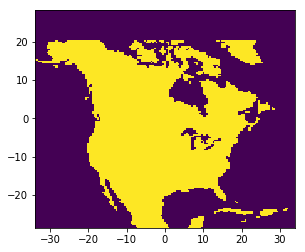

In [15]:
plt.imshow(mask10_ext[key], origin='lower', extent=extent)

# Clip raster from vector

Each grid cell in the CanRCM4 model has an extent that is considered in this mask. In order to account for this, a grid cell is considered included in the mask if it intersects with the geometry of the polygon we provide. 

`gen_raster_mask_from_vector` generates this mask using the coordinates from the coordinates provided

In [16]:
final_mask = gen_raster_mask_from_vector(mask10_ext.rlon.values, mask10_ext.rlat.values,  canada)

100%|██████████| 1051830/1051830 [04:56<00:00, 3550.72it/s]


Write to NetCDF file

In [21]:
new_mask = gen_dataset('mask', final_mask, mask10_ext.rlon.values, mask10_ext.rlat.values)

new_mask.to_netcdf('canada_mask_rp.nc')

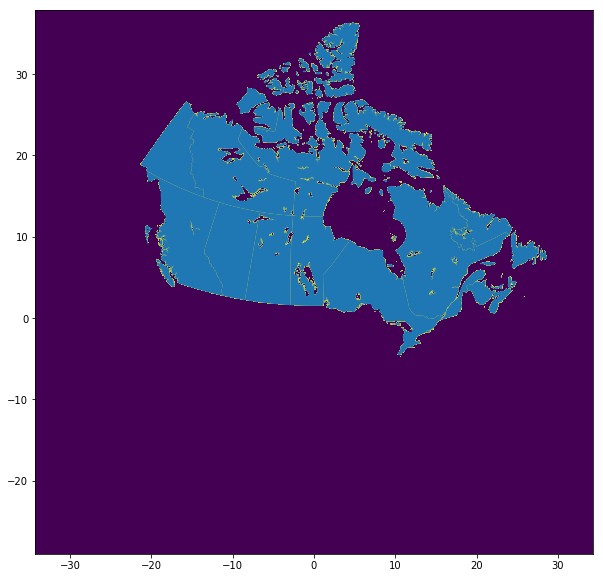

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(final_mask, origin='lower', extent=new_extent)
canada.plot(ax=ax)